In [44]:
# import torch
# import pyro
# import matplotlib.pyplot as plt
# from src.model import linear_regression_model, generate_data
# from src.inference import run_inference

# from src.model import logistic_regression_model_two_factors, generate_data_two_factors


In [45]:
# # Generate synthetic data
# x, y = generate_data()

# # Run inference
# svi, guide = run_inference(linear_regression_model, x, y)

# # Extract the posterior parameters
# alpha_mean = pyro.param("AutoNormal.locs.alpha").item()
# beta_mean = pyro.param("AutoNormal.locs.beta").item()
# sigma_mean = pyro.param("AutoNormal.locs.sigma").item()

# print(f"Inferred parameters: alpha={alpha_mean:.2f}, beta={beta_mean:.2f}, sigma={sigma_mean:.2f}")

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.scatter(x, y, alpha=0.5, label="Data")
# plt.plot(x, alpha_mean + beta_mean * x, color='red', label="Inferred Regression Line")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.legend()
# plt.title("Bayesian Linear Regression with Pyro")
# plt.show()

In [7]:
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoMultivariateNormal

from src.model import logistic_regression_model_two_factors, generate_data_two_factors

# Generate data
num_points = 10000
beta_r_true = 0.8
beta_p_true = -2
x, y = generate_data_two_factors(num_points=num_points, beta_r_true=beta_r_true, beta_p_true=beta_p_true)

# Define model 
model = logistic_regression_model_two_factors

# Inference parameters
num_iterations = 1000

# Clear the param store in case we're rerunning this cell
pyro.clear_param_store()

# Define the guide using AutoMultivariateNormal to learn a multivariate posterior
guide = AutoMultivariateNormal(model)

# Set up the optimizer and inference method
optimizer = Adam({"lr": 0.01, "betas": (0.90, 0.999)})
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Perform inference
num_steps = 10000
for step in range(num_steps):
    loss = svi.step(x, y)
    if step % 500 == 0:
        print(f"Step {step}, Loss: {loss}, Loc: {guide.loc.data}")

# After training, access the learned multivariate posterior
posterior_params = guide.median()
print(f"Posterior mean for beta_r: {posterior_params['beta_r']}")
print(f"Posterior mean for beta_p: {posterior_params['beta_p']}")


pr: 0.8, pp: 0.11920292202211755, pr * pp: 0.09536233761769404
Step 0, Loss: 4722.509303808212, Loc: tensor([ 0.8000, -0.5372])
Step 500, Loss: 3165.2625155448914, Loc: tensor([ 0.4063, -1.1759])
Step 1000, Loss: 3165.3600177764893, Loc: tensor([ 0.4835, -1.3846])
Step 1500, Loss: 3161.9410393238068, Loc: tensor([ 0.5859, -1.6161])
Step 2000, Loss: 3159.6587097644806, Loc: tensor([ 0.6836, -1.8336])
Step 2500, Loss: 3156.4187499284744, Loc: tensor([ 0.7605, -1.9360])
Step 3000, Loss: 3157.7985937595367, Loc: tensor([ 0.7963, -1.9782])
Step 3500, Loss: 3160.0158182382584, Loc: tensor([ 0.7979, -2.0049])
Step 4000, Loss: 3162.9266089200974, Loc: tensor([ 0.8185, -1.9979])
Step 4500, Loss: 3158.7914649248123, Loc: tensor([ 0.8152, -2.0043])
Step 5000, Loss: 3158.602110981941, Loc: tensor([ 0.8077, -1.9925])
Step 5500, Loss: 3158.80475127697, Loc: tensor([ 0.7928, -1.9935])
Step 6000, Loss: 3159.031025528908, Loc: tensor([ 0.7945, -2.0144])
Step 6500, Loss: 3158.8946746587753, Loc: tensor(

In [8]:
guide.loc, torch.sqrt(guide.scale), guide.scale_tril

(Parameter containing:
 tensor([ 0.8010, -1.9715], requires_grad=True),
 tensor([0.2972, 0.1818], grad_fn=<SqrtBackward0>),
 tensor([[ 1.0000,  0.0000],
         [-3.2999,  1.0000]], grad_fn=<AddBackward0>))

In [9]:
scale_tril = guide.scale[..., None] * guide.scale_tril
scale_tril @ scale_tril.T

tensor([[ 0.0078, -0.0096],
        [-0.0096,  0.0130]], grad_fn=<MmBackward0>)

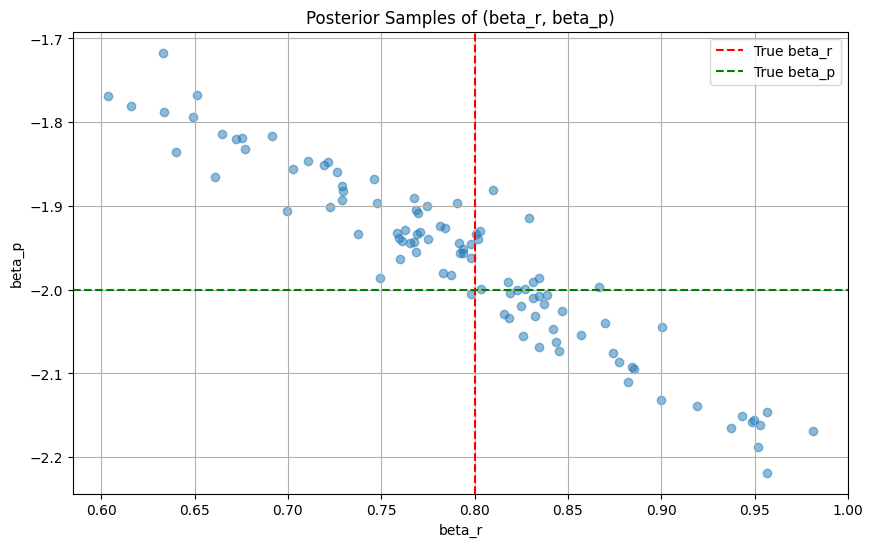

In [10]:
n_sample = 100
a_samples = []
b_samples = []
for _ in range(n_sample):
    param_sample = guide.forward()
    a_samples.append(param_sample['beta_r'].item())
    b_samples.append(param_sample['beta_p'].item())

plt.figure(figsize=(10, 6))
plt.scatter(a_samples, b_samples, alpha=0.5)
plt.xlabel('beta_r')
plt.ylabel('beta_p')
plt.title('Posterior Samples of (beta_r, beta_p)')
plt.axvline(x=beta_r_true, color='r', linestyle='--', label='True beta_r')
plt.axhline(y=beta_p_true, color='g', linestyle='--', label='True beta_p')
plt.legend()
plt.grid(True)
plt.show()

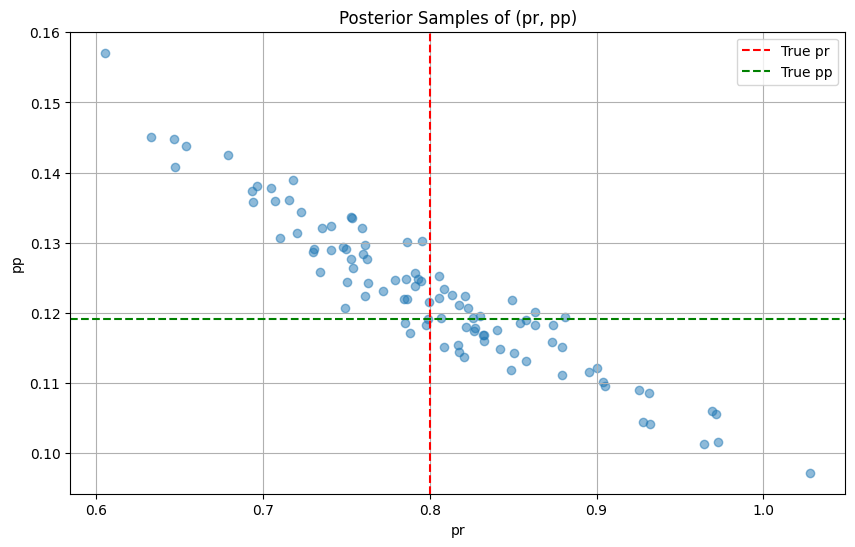

In [11]:
n_sample = 100
a_samples = []
b_samples = []
for _ in range(n_sample):
    param_sample = guide.forward()
    # a_samples.append(1 / (1 + np.exp(-param_sample['beta_r'].item())))
    a_samples.append(param_sample['beta_r'].item())
    b_samples.append(1 / (1 + np.exp(-param_sample['beta_p'].item())))

plt.figure(figsize=(10, 6))
plt.scatter(a_samples, b_samples, alpha=0.5)
plt.xlabel('pr')
plt.ylabel('pp')
plt.title('Posterior Samples of (pr, pp)')
# plt.axvline(x=1 / (1 + np.exp(-beta_r_true)), color='r', linestyle='--', label='True pr')
plt.axvline(x=beta_r_true, color='r', linestyle='--', label='True pr')
plt.axhline(y=1 / (1 + np.exp(-beta_p_true)), color='g', linestyle='--', label='True pp')
plt.legend()
plt.grid(True)
plt.show()

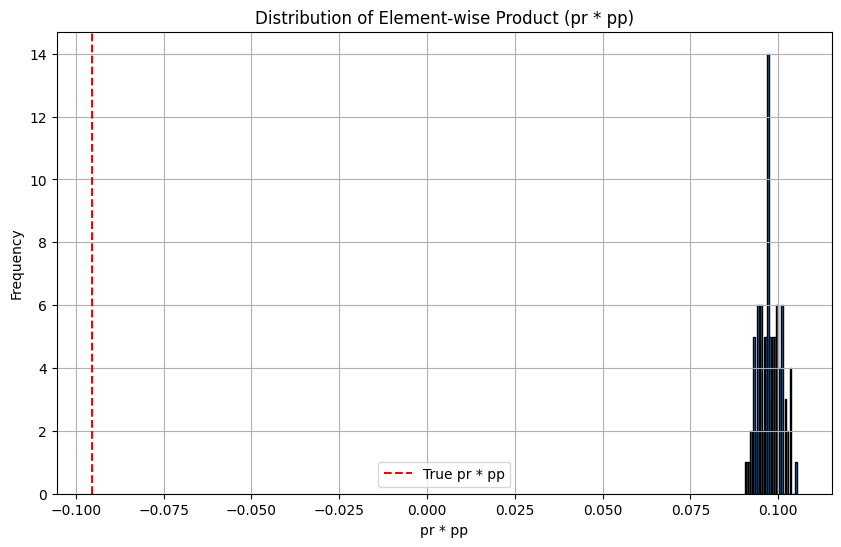

In [12]:
# Calculate element-wise product of a_samples and b_samples
product_samples = [a * b for a, b in zip(a_samples, b_samples)]

# Plot the distribution of the product
plt.figure(figsize=(10, 6))
plt.hist(product_samples, bins=30, edgecolor='black')
plt.xlabel('pr * pp')
plt.ylabel('Frequency')
plt.title('Distribution of Element-wise Product (pr * pp)')
plt.axvline(x=(-beta_r_true) * (1 / (1 + np.exp(-beta_p_true))), 
            color='r', linestyle='--', label='True pr * pp')
plt.legend()
plt.grid(True)
plt.show()
